## Read and Explore Data

In [1]:
import pandas as pd

file = r'data\ACLED_event_data_with_COCOM.csv'

df_event=pd.read_csv(file)
print(df_event.head())
print('')
print(df_event.info())


   data_id        event_date                  event_type  \
0  6714112  18 December 2019                     Battles   
1  6715905  18 December 2019                    Protests   
2  6860033  18 December 2019  Violence against civilians   
3  6714114  18 December 2019  Explosions/Remote violence   
4  6715651  18 December 2019                    Protests   

                   sub_event_type          region     country  \
0                     Armed clash  Eastern Africa     Somalia   
1                Peaceful protest   Southern Asia       India   
2  Abduction/forced disappearance  Eastern Africa  Mozambique   
3   Remote explosive/landmine/IED  Eastern Africa     Somalia   
4                Peaceful protest   Southern Asia       India   

          location  latitude  longitude  fatalities iso3        COCOM  
0           Baidoa    3.1172    43.6469           0  SOM    USAFRICOM  
1        Amaravati   16.5752    80.3580           0  IND  USINDOPACOM  
2          Chimoio  -19.1164    

In [2]:
# Convert 'event_date' column to datetime
df_event['event_date'] = pd.to_datetime(df_event['event_date'])

# Optional: Sort by date
df_event = df_event.sort_values('event_date')

print(f"Earliest date is: {df_event['event_date'].head(1)}")
print('')
print(f"Latest date is: {df_event['event_date'].tail(1)}")

Earliest date is: 0   2019-12-18
Name: event_date, dtype: datetime64[ns]

Latest date is: 24158   2020-02-15
Name: event_date, dtype: datetime64[ns]


## Example of Analyze Temporal Patterns

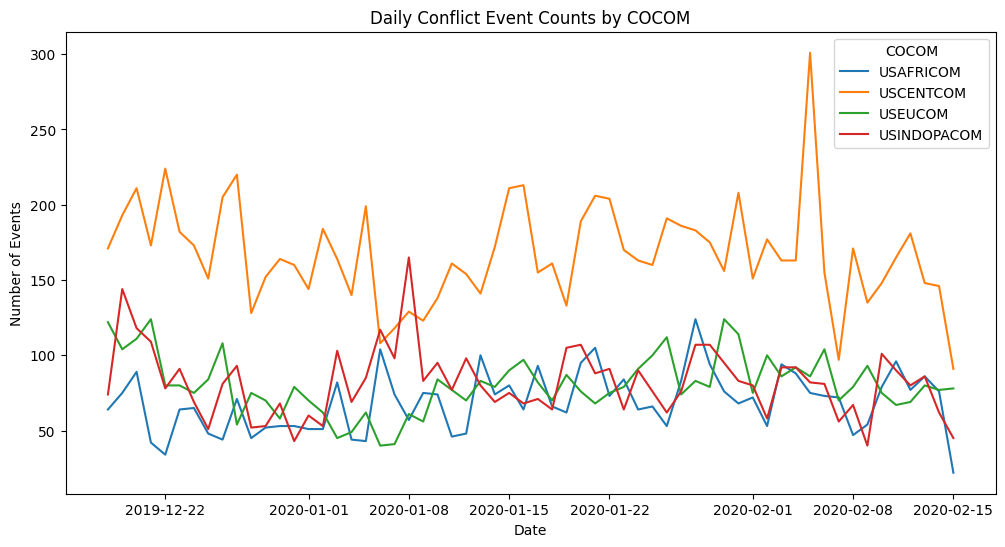

In [3]:
import matplotlib.pyplot as plt

# List of the four primary COCOMs of interest
cocoms = ['USAFRICOM', 'USCENTCOM', 'USEUCOM', 'USINDOPACOM']

# Group by event_date and COCOM, count events per day per COCOM
daily_counts = df_event.groupby(['event_date', 'COCOM']).size().unstack(fill_value=0)

# Filter to only the four COCOMs of interest
daily_counts = daily_counts[cocoms]

# Plot
plt.figure(figsize=(12,6))
for cocom in cocoms:
    plt.plot(daily_counts.index, daily_counts[cocom], label=cocom)

plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.title('Daily Conflict Event Counts by COCOM')
plt.legend(title='COCOM')

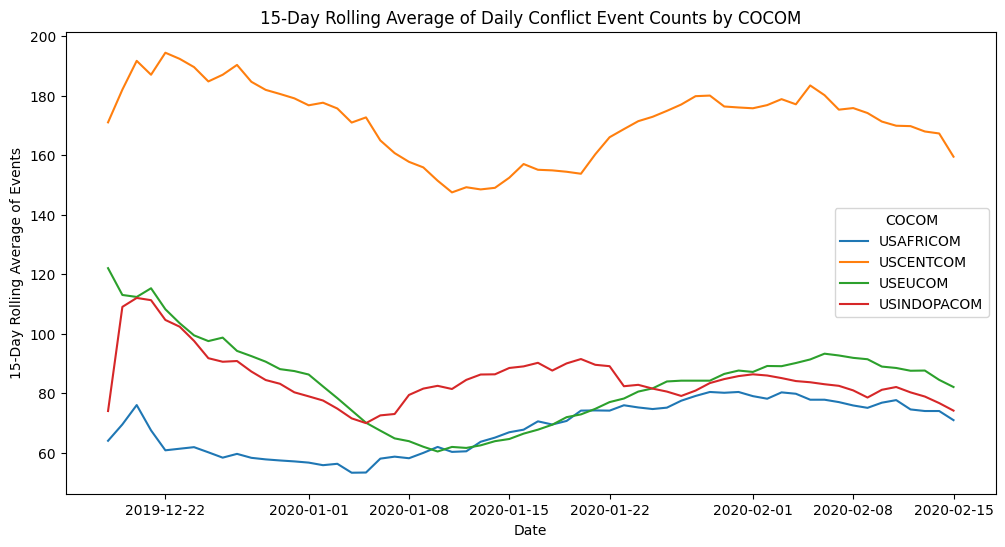

In [4]:
# Calculate 15-day rolling average
rolling_counts = daily_counts.rolling(window=15, min_periods=1).mean()

# Plot
plt.figure(figsize=(12,6))
for cocom in cocoms:
    plt.plot(rolling_counts.index, rolling_counts[cocom], label=cocom)

plt.xlabel('Date')
plt.ylabel('15-Day Rolling Average of Events')
plt.title('15-Day Rolling Average of Daily Conflict Event Counts by COCOM')
plt.legend(title='COCOM')


Event with the most fatalities:
data_id                                     6719701
event_date                      2020-01-08 00:00:00
event_type               Explosions/Remote violence
sub_event_type    Shelling/artillery/missile attack
region                                  Middle East
country                                        Iran
location                                     Parand
latitude                                    35.4719
longitude                                   50.9754
fatalities                                      176
iso3                                            IRN
COCOM                                     USCENTCOM
Name: 8506, dtype: object


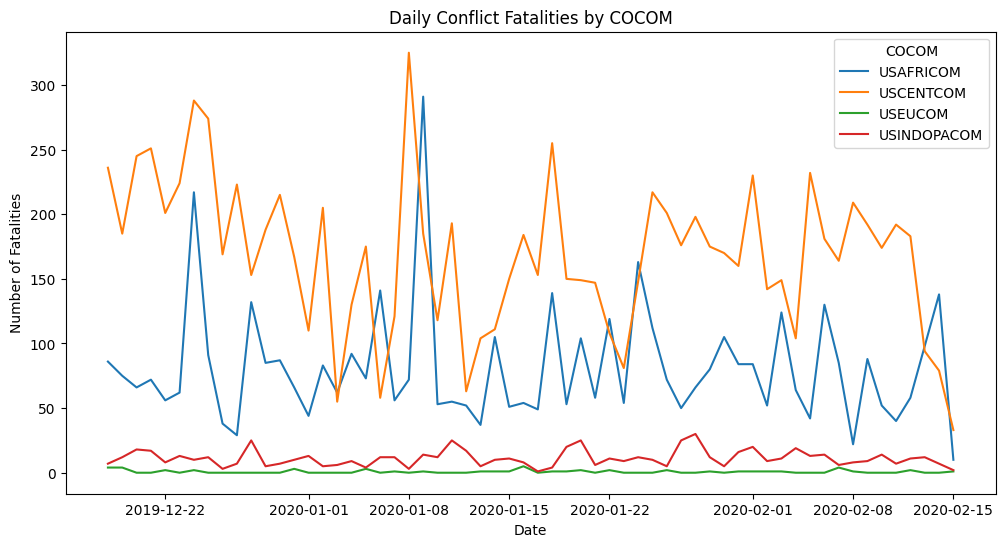

In [5]:
# Group by event_date and COCOM, sum fatalities per day per COCOM
daily_deaths = df_event.groupby(['event_date', 'COCOM'])['fatalities'].sum().unstack(fill_value=0)

# Filter to only the four COCOMs of interest
daily_deaths = daily_deaths[cocoms]

# Plot
plt.figure(figsize=(12,6))
for cocom in cocoms:
    plt.plot(daily_deaths.index, daily_deaths[cocom], label=cocom)

plt.xlabel('Date')
plt.ylabel('Number of Fatalities')
plt.title('Daily Conflict Fatalities by COCOM')
plt.legend(title='COCOM')


# Identify the event with the most fatalities
max_fatal_event = df_event.loc[df_event['fatalities'].idxmax()]
print("Event with the most fatalities:")
print(max_fatal_event)

### Creation of a Heatmap of Event Types


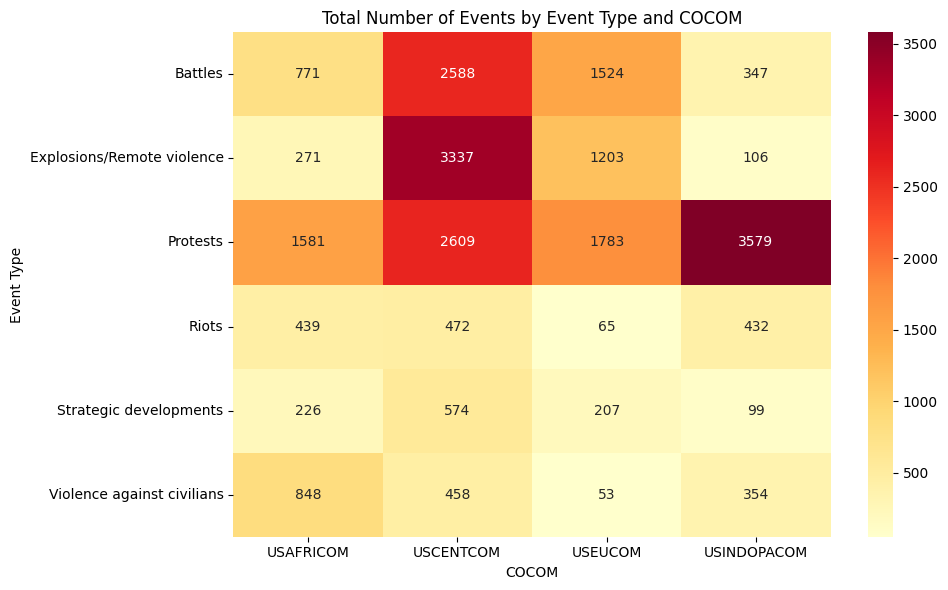

In [6]:
import seaborn as sns

# Create a pivot table: rows=event_type, columns=COCOM, values=event counts
heatmap_data = df_event.pivot_table(index='event_type', columns='COCOM', values='data_id', aggfunc='count', fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Total Number of Events by Event Type and COCOM')
plt.xlabel('COCOM')
plt.ylabel('Event Type')
plt.tight_layout()
plt.show()

### Creation of an interactive map

In [7]:
import folium
from folium.plugins import MarkerCluster, MiniMap

# Filter for CENTCOM events on Jan 7 and 8, 2020
mask = (
    (df_event['COCOM'] == 'USCENTCOM') &
    (df_event['event_date'].isin([pd.Timestamp('2020-01-07'), pd.Timestamp('2020-01-08')]))
)
centcom_events = df_event[mask]

# Calculate map center
map_center = [centcom_events['latitude'].mean(), centcom_events['longitude'].mean()]

# Create map
m = folium.Map(location=map_center, zoom_start=5, tiles='CartoDB positron')

# Add marker cluster for better visualization
marker_cluster = MarkerCluster().add_to(m)

# Add markers with detailed popup
for _, row in centcom_events.iterrows():
    popup_text = f"""
    <b>Date:</b> {row['event_date'].date()}<br>
    <b>Event Type:</b> {row['event_type']}<br>
    <b>Sub Event Type:</b> {row['sub_event_type']}<br>
    <b>Country:</b> {row['country']}<br>
    <b>Location:</b> {row['location']}<br>
    <b>Latitude:</b> {row['latitude']}<br>
    <b>Longitude:</b> {row['longitude']}<br>
    <b>Fatalities:</b> {row['fatalities']}
    """
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(popup_text, max_width=350),
        tooltip=row['event_type'],
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(marker_cluster)

# Add a minimap plugin for extra context
minimap = MiniMap(toggle_display=True)
m.add_child(minimap)

# Display map in notebook
m

# Optionally, save HTML
# m.save('centcom_events_jan7_8.html')